In [1]:
import os
import sys
import statistics
sys.path.insert(1, '/mnt/d/PowerTAC/Python/python_utils/helper') 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from statistics import mean
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from read_mongo_collection import HelperToReadMongo

sns.set_theme(style="darkgrid")

# See complete data
pd.set_option('max_columns', None)
pd.set_option("max_rows", None)
np.set_printoptions(threshold=np.inf)

In [3]:
helper_mongo = HelperToReadMongo()

In [4]:
rename_col = {"MCP": "Price", "LimitPrice": "Price" , "Net_Cleared_Quantity": "Quantity", \
              "Broker's_Cleared_Quantity": "Quantity", "Broker's_Bidded_Quantity": "Quantity", \
              "Market_Position": "Quantity"}

In [5]:
color_book = {'DDPGBBS': 'cornflowerblue', 'VidyutVanika': 'slateblue', 'VV20': 'slateblue', 'VidyutVanika18': 'lightgreen', 'VV': 'lightgreen', 'VV2': 'lightgreen', \
              'ZI': 'plum', 'ZI2': 'plum', 'ZIP': 'slategray', 'ZIP2': 'slategray', 'SPOT': 'lightsalmon', 'SPOT2': 'lightsalmon', 'Sample': 'gold', 'MCP': 'red'}

def get_colors(list_of_brokers):
    return [color_book.get(broker) for broker in list_of_brokers]

# Data Processing

In [6]:
# Specify names of all the databases here
# list_of_databases = ['PowerTAC2021_DDPG_Test4_1', 'PowerTAC2021_VV18_Test4_1']
list_of_databases = ['PowerTAC2021_DDPG_Test_9', 'PowerTAC2021_SPOT_Test_9', 'PowerTAC2021_SPOT2_Test_9',
                     'PowerTAC2021_VV18_Test_9', 'PowerTAC2021_VV182_Test_9', 'PowerTAC_DDPG_Test_ZI_9', 
                     'PowerTAC_DDPG_Test_ZI2_9', 'PowerTAC_DDPG_Test_ZIP_9', 'PowerTAC_DDPG_Test_ZIP2_9']

# Specify names of all the brokers corresponding to databases here
# list_of_brokers = ['DDPGBBS', 'VV18']
list_of_brokers = ['DDPGBBS', 'SPOT', 'SPOT2', 'VV', 'VV2', 'ZI', 'ZI2', 'ZIP', 'ZIP2']

# Specify the storage path along with directory
storage_path = '/mnt/d/PowerTAC/PowerTAC2021/experiments/Wholesale_Executables/final/Full9'
os.makedirs(storage_path, exist_ok=False) 

# Specify list of the collections to be analysed here
# list_of_collections = helper_mongo.connect_to_mongo('PowerTAC2020_Wholesale_Test_VV21').list_collection_names()
list_of_collections = ['MarketTransaction_Info', 'Submitted_Bid_Information', 'ClearedTrade_Info', 
                       'Cash_and_Market_Position_Info']

# Keep all the collections at one place
dict_of_dataframes = dict()

In [7]:
# View the Collections in all the databases

def view_collections(list_of_databases):
    
    for database in list_of_databases:
        
        db = helper_mongo.connect_to_mongo(database, server_ip='10.2.16.159', ssh_username='powertac', \
                                           ssh_password='sanjay9397', remote=True)
#         db = helper_mongo.connect_to_mongo(database, server_ip='192.168.43.49', ssh_username='user', \
#                                            ssh_password='sanjay9397', remote=True)
        print(database + "\n" + "-"*35)
        print(db.list_collection_names())
        print("\n")

# Function Calling
view_collections(list_of_databases)

PowerTAC2021_DDPG_Test_9
-----------------------------------
['Submitted_Bid_Information', 'ClearedTrade_Info', 'MarketTransaction_Info', 'Cash_and_Market_Position_Info']


PowerTAC2021_SPOT_Test_9
-----------------------------------
['ClearedTrade_Info', 'MarketTransaction_Info', 'Cash_and_Market_Position_Info', 'Submitted_Bid_Information']


PowerTAC2021_SPOT2_Test_9
-----------------------------------
['MarketTransaction_Info', 'ClearedTrade_Info', 'Submitted_Bid_Information', 'Cash_and_Market_Position_Info']


PowerTAC2021_VV18_Test_9
-----------------------------------
['Submitted_Bid_Information', 'ClearedTrade_Info', 'Cash_and_Market_Position_Info', 'MarketTransaction_Info']


PowerTAC2021_VV182_Test_9
-----------------------------------
['MarketTransaction_Info', 'Cash_and_Market_Position_Info', 'ClearedTrade_Info', 'Submitted_Bid_Information']


PowerTAC_DDPG_Test_ZI_9
-----------------------------------
['MarketTransaction_Info', 'Cash_and_Market_Position_Info', 'ClearedTrade

In [8]:
for dataset, broker in zip(list_of_databases, list_of_brokers):
    
    inner_dict = dict()
    
    # igames = ['finals_2019_07_124_4224']
        
    for collection in list_of_collections:
        
        db = helper_mongo.query_to_mongo(dataset, collection, server_ip='10.2.16.159', ssh_username='powertac', \
                                         ssh_password='sanjay9397', remote=True)
#         db = helper_mongo.query_to_mongo(dataset, collection, server_ip='192.168.43.49', ssh_username='user', \
#                                          ssh_password='sanjay9397', remote=True)
        db.rename(columns = rename_col, inplace = True)
        # db = db[db.Game_Name.isin(igames)]    # to select a subset of games
        
        if collection not in ['Cash_and_Market_Position_Info']:
            db = db[abs(db['Quantity']) > 0.05] 
            # if (collection != 'ClearedTrade_Info'):
            #    # consider only bids
            #    db = db[db['Price'] < 0.0]
            db['Proximity'] = db['Execution_Timeslot'] - db['Bidding_Timeslot']
            
        inner_dict.update({collection: db})
                
    dict_of_dataframes.update({broker: inner_dict})

In [9]:
test_database = dict_of_dataframes.get('DDPGBBS').get('Submitted_Bid_Information').copy(deep=True)
print(test_database.Game_Name.unique())
num_games = len(test_database.Game_Name.unique())

['finals_2019_07_400_7231' 'finals_2019_07_344_9658'
 'finals_2019_07_304_5096' 'finals_2019_07_23_1108' 'finals_2019_07_7_851'
 'finals_2019_07_398_6817']


# Analysis and Plotting

### Total Wholesale Cost Comparison

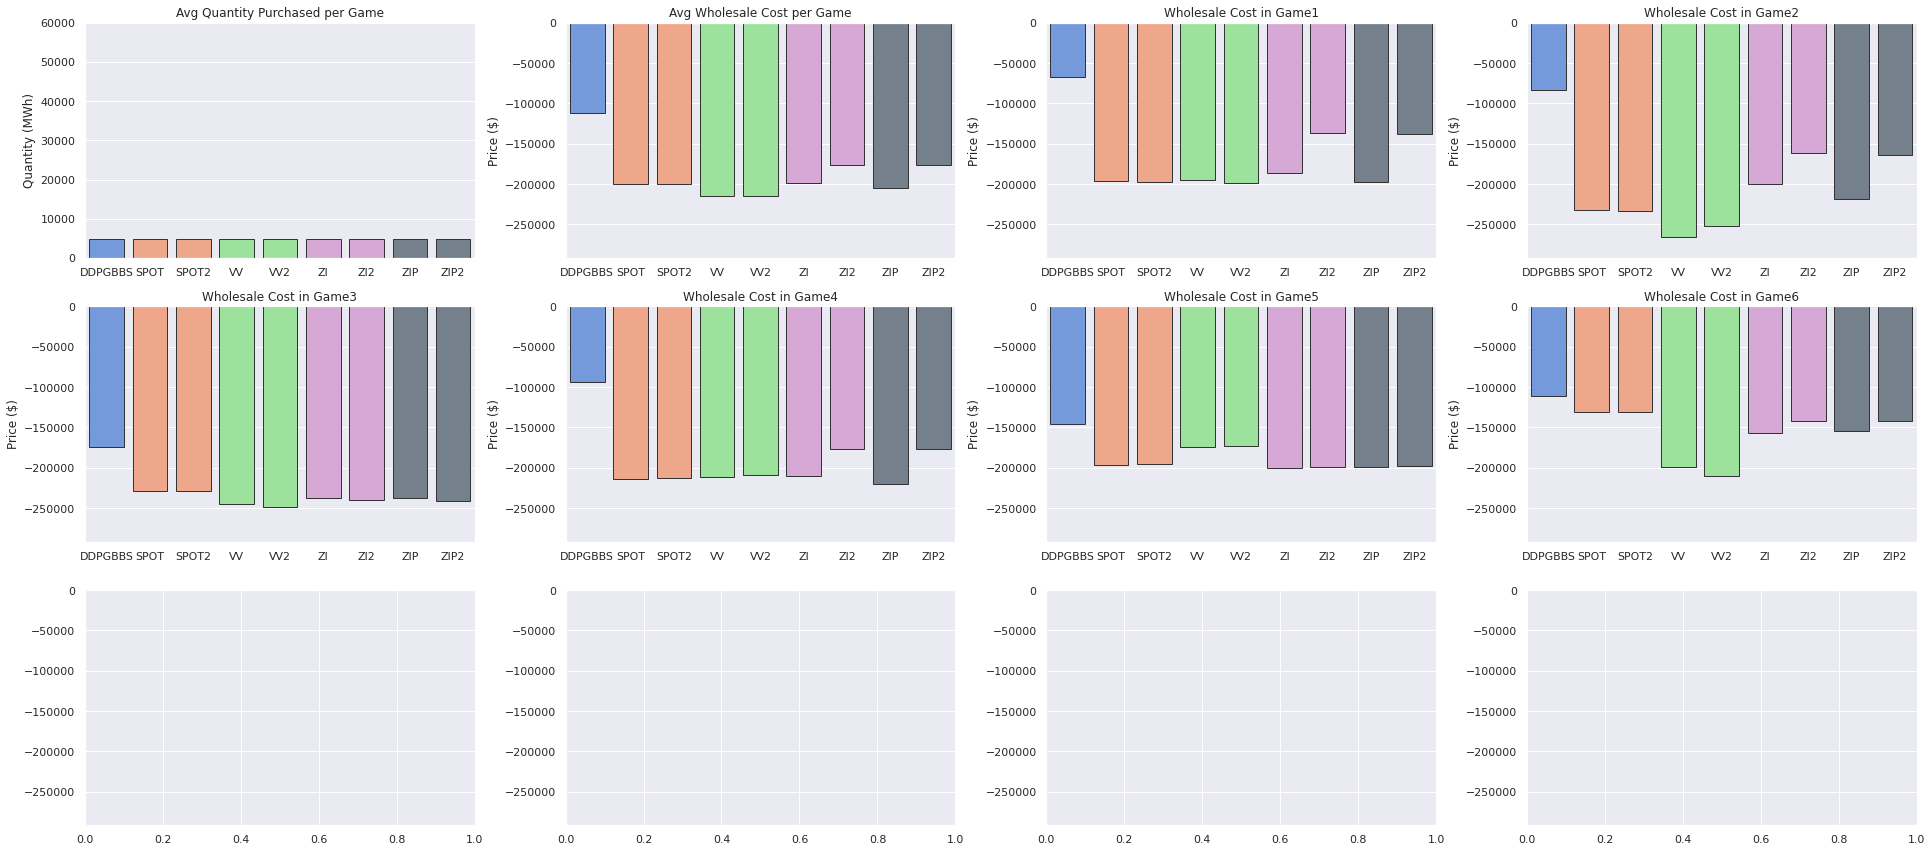

In [10]:
cost_list = list()
quan_list = list()

highest = np.inf

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
        
for broker in list_of_brokers:

    db = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)
    db['W_Cost'] = db['Quantity'] * db['Price']
    cost = (db['W_Cost'].sum() / len(db.Game_Name.unique()))
    quan = (db['Quantity'].sum() / len(db.Game_Name.unique()))

    cost_list.append(cost)
    quan_list.append(quan) 
    
cost_dict = dict()

for broker in list_of_brokers:
        
    database = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        db['W_Cost'] = db['Quantity'] * db['Price']
        cost = (db['W_Cost'].sum() / len(db.Game_Name.unique()))

        clist = cost_dict.get(i)

        if cost < highest:
            highest = cost

        if clist == None:
            clist = [cost]
        else:
            clist.append(cost)

        cost_dict.update({i: clist})

###############################################
############ Plot using Seaborn ###############
###############################################

def wholesale_money():    
    
    sns.barplot(x=list_of_brokers, y=quan_list, ax = axes[0][0], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Quantity (MWh)', title='Avg Quantity Purchased per Game')
    sns.barplot(x=list_of_brokers, y=cost_list, ax = axes[0][1], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Price ($)', title='Avg Wholesale Cost per Game') 
           
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(x=list_of_brokers, y=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Price ($)', title='Wholesale Cost in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.setp(axes, ylim=(highest*1.1, 0))
    plt.setp(axes[0][0], ylim=(0, 6*1e4))
    plt.tight_layout()
    plt.savefig(storage_path + "/wholesale_cost_comparison.jpg")

    
###############################################
############ Plot using Plotly ################
###############################################
    
def wholesale_money_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Avg Quantity Purchased per Game', 'Avg Wholesale Cost per Game', 'Wholesale Cost in Game1', 'Wholesale Cost in Game2', 'Wholesale Cost in Game3',
                                        'Wholesale Cost in Game4', 'Wholesale Cost in Game5', 'Wholesale Cost in Game6', 'Wholesale Cost in Game7', 'Wholesale Cost in Game8', 'Wholesale Cost in Game9', 'Wholesale Cost in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)    
    
    fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=quan_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = 1, col = 1)
    
    fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = 1, col = 2)
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_dict.get(k),
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
            
    fig.update_yaxes(title_text="Cost ($)", range=[highest*1.1, 0])
    fig.update_yaxes(title_text="Quantity (MWh)", row=1, col=1, range=[0, 6*1e4])
    
    fig.update_layout(
        height=750, 
        width=1400, 
        title_text='Wholesale Cost Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.0)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/wholesale_cost_comparison.html")
    
    
###############################################
############## Function Call ##################
###############################################

wholesale_money()
wholesale_money_plotly()

### Avg Per Unit Price Comparison

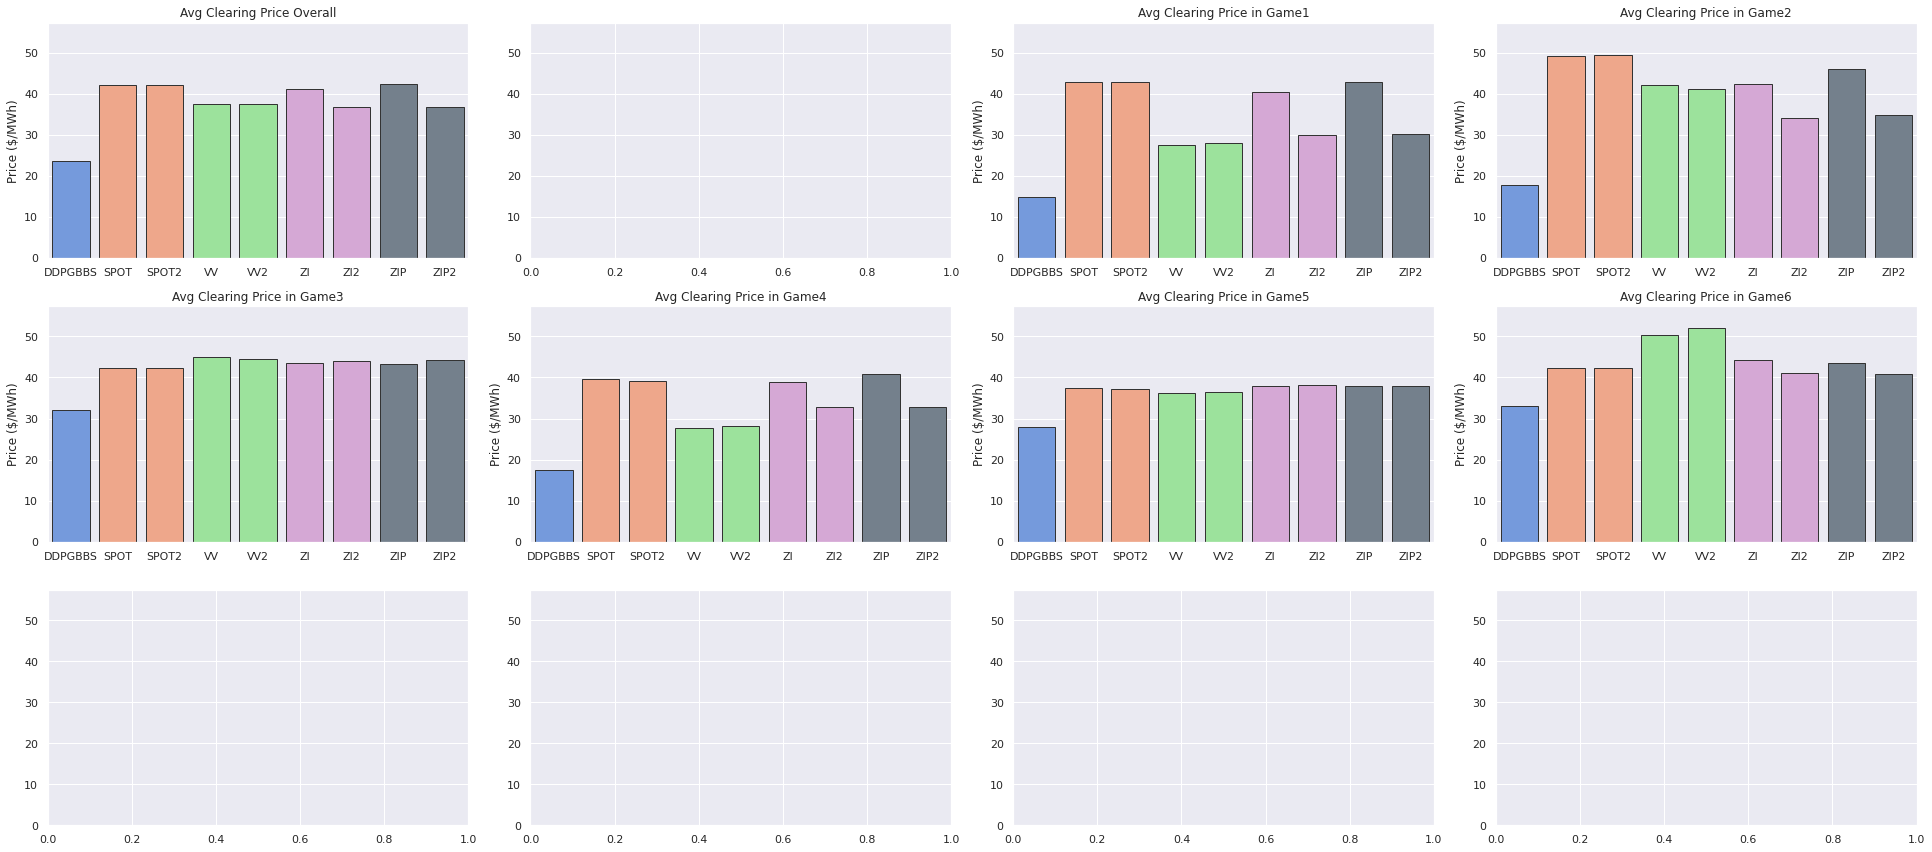

In [11]:
cost_list = list()
    
highest = -np.inf

for broker in list_of_brokers:
        
    db = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)
    db = db[db['Price'] < 0.0]  # only buying

    db['W_Cost'] = db['Quantity'] * db['Price']
    cost = abs(db['W_Cost'].sum() / db['Quantity'].sum())

    cost_list.append(cost)
    
cost_dict = dict()
    
for broker in list_of_brokers:

    database = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        db = db[db['Price'] < 0.0]  # only buying

        db['W_Cost'] = db['Quantity'] * db['Price']
        cost = abs(db['W_Cost'].sum() / db['Quantity'].sum())

        clist = cost_dict.get(i)

        if cost > highest:
            highest = cost

        if clist == None:
            clist = [cost]
        else:
            clist.append(cost)

        cost_dict.update({i: clist})

###############################################
############ Plot using Seaborn ###############
###############################################

def unit_buying_price():    
        
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
         
    sns.barplot(x=list_of_brokers, y=cost_list, ax = axes[0][0], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Price ($/MWh)', title='Avg Clearing Price Overall')
        
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(x=list_of_brokers, y=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Price ($/MWh)', title='Avg Clearing Price in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.setp(axes, ylim=(0, highest*1.1))
    plt.tight_layout()
    plt.savefig(storage_path + "/clearing_price_comparison.jpg")
    
    
###############################################
############ Plot using Plotly ################
###############################################
    
def unit_buying_price_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Avg Clearing Price Overall', '', 'Avg Clearing Price in Game1', 'Avg Clearing Price in Game2', 'Avg Clearing Price in Game3',
                                        'Avg Clearing Price in Game4', 'Avg Clearing Price in Game5', 'Avg Clearing Price in Game6', 'Avg Clearing Price in Game7', 'Avg Clearing Price in Game8', 'Avg Clearing Price in Game9', 'Avg Clearing Price in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)
    
    fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = 1, col = 1)
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_dict.get(k),
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
            
    fig.update_yaxes(title_text="Price ($/MWh)", range=[0, highest*1.1])
    
    fig.update_layout(
        height=750, 
        width=1400, 
        title_text='Clearing Price Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.0)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/clearing_price_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
unit_buying_price()
unit_buying_price_plotly()

In [12]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [13]:
cost_list = list()
    
highest = -np.inf

for broker in list_of_brokers:
        
    db = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)
    db = db[db['Price'] < 0.0]  # only buying

    db['W_Cost'] = db['Quantity'] * db['Price']
    cost = abs(db['W_Cost'].sum() / db['Quantity'].sum())

    cost_list.append(cost)
    
cost_dict = dict()
    
for broker in list_of_brokers:

    database = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        db = db[db['Price'] < 0.0]  # only buying

        db['W_Cost'] = db['Quantity'] * db['Price']
        cost = abs(db['W_Cost'].sum() / db['Quantity'].sum())

        clist = cost_dict.get(i)

        if cost > highest:
            highest = cost

        if clist == None:
            clist = [cost]
        else:
            clist.append(cost)

        cost_dict.update({i: clist})
        
stdev_list = []

for i in range(len(list_of_brokers)):
    stdev_list.append(statistics.pstdev(cost_dict.get(i)))
    
###############################################
############ Plot using Seaborn ###############
###############################################

fig = go.Figure()

fig.add_trace(go.Bar(
        x=list_of_brokers, 
        y=cost_list,
        marker_color=get_colors(list_of_brokers),
    error_y=dict(type='data', array=stdev_list),
))

fig.update_yaxes(title_text="Price ($/MWh)", range=[0, highest*1.1])
    
fig.update_layout(
    height=600, 
    width=800, 
    template='seaborn',
    font=dict(
#         family="Courier New, monospace",
        size=24,
    )
)

fig.update_traces(marker_line_color='black', marker_line_width=1.0)
fig.show()
fig.write_html(storage_path + "/clearing_price_comparison_new.html")


TypeError: 'NoneType' object is not iterable

###  Average Quanitity Bought Per Timeslot Comparison 

In [ ]:
cost_list = list()
    
highest = -np.inf

for broker in list_of_brokers:
        
    db = dict_of_dataframes.get(broker).get('Cash_and_Market_Position_Info').copy(deep=True)
    cost = db['Quantity'].mean()

    cost_list.append(cost)
    
cost_dict = dict()
    
for broker in list_of_brokers:

    database = dict_of_dataframes.get(broker).get('Cash_and_Market_Position_Info').copy(deep=True)

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        cost = db['Quantity'].mean()

        clist = cost_dict.get(i)

        if cost > highest:
            highest = cost

        if clist == None:
            clist = [cost]
        else:
            clist.append(cost)

        cost_dict.update({i: clist})

###############################################
############ Plot using Seaborn ###############
###############################################

def quantity_bought():    
            
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
           
    sns.barplot(x=list_of_brokers, y=cost_list, ax = axes[0][0], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Quantity (MWh)', title='Avg Quantity Purchased per Timeslot Overall')
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(x=list_of_brokers, y=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Quantity (MWh)', title='Avg Quantity Purchased per Timeslot in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.setp(axes, ylim=(0, highest*1.1))
    plt.tight_layout()
    plt.savefig(storage_path + "/quantity_purchased_per_timeslot_comparison.jpg")
    
    
###############################################
############ Plot using Plotly ################
###############################################
    
def quantity_bought_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Avg Quantity Purchased per Timeslot Overall', '', 'Avg Quantity Purchased per Timeslot in Game1', 'Avg Quantity Purchased per Timeslot in Game2', 'Avg Quantity Purchased per Timeslot in Game3',
                                        'Avg Quantity Purchased per Timeslot in Game4', 'Avg Quantity Purchased per Timeslot in Game5', 'Avg Quantity Purchased per Timeslot in Game6', 'Avg Quantity Purchased per Timeslot in Game7', 
                                        'Avg Quantity Purchased per Timeslot in Game8', 'Avg Quantity Purchased per Timeslot in Game9', 'Avg Quantity Purchased per Timeslot in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)
    
    fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = 1, col = 1)
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_dict.get(k),
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
            
    fig.update_yaxes(title_text="Quantity (MWh)", range=[0, highest*1.1])
    
    fig.update_layout(
        height=750, 
        width=1400, 
        title_text='Quantity Purchased per Timeslot Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.0)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/quantity_purchased_per_timeslot_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
quantity_bought()
quantity_bought_plotly()

### Limit-price and Clearing-price Comparison 

In [ ]:
###############################################
############ Plot using Plotly ################
###############################################
    
def limitprice_vs_mcp_plotly():    
    
    num_rows = 4
    num_cols = 1
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Overall Limit-price Comparison', 'Limit-price Comparsion (When Bids get Cleared)', 'Clearing-price Comparsion', 'MCP'),
                        vertical_spacing=0.10)
                    
    for broker, i in zip(list_of_brokers, range(1, len(list_of_brokers)+1)):
        
        db_sb = dict_of_dataframes.get(broker).get('Submitted_Bid_Information').copy(deep=True)
        db_mt = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)
        
        groupby_db_sb = (db_sb.groupby(['Game_Name', 'Execution_Timeslot']).mean()).groupby('Execution_Timeslot').mean()
        cp_sb = abs(groupby_db_sb['Price'])

        db = pd.merge(db_sb, db_mt,  how='right', 
                             left_on=['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'], 
                             right_on = ['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'])

        db = db[db['Price_y'] < 0.0] 
        groupby_db = (db.groupby(['Game_Name', 'Execution_Timeslot']).mean()).groupby('Execution_Timeslot').mean()
        lp = abs(groupby_db['Price_x'])
        cp = abs(groupby_db['Price_y'])    
        
        fig.append_trace(go.Scatter(x = cp_sb.index.tolist(),
                                    y = cp_sb, 
                                    name = broker,
                                    line=dict(color=color_book.get(broker)),
                                    legendgroup = 1
                                   ), row = 1, col = 1)
        
        fig.append_trace(go.Scatter(x = lp.index.tolist(),
                                    y = lp, 
                                    name = broker,
                                    line=dict(color=color_book.get(broker)),
                                    legendgroup = 1,
                                    showlegend=False
                                   ), row = 2, col = 1)
        
        fig.append_trace(go.Scatter(x = cp.index.tolist(),
                                    y = cp, 
                                    name = broker,
                                    line=dict(color=color_book.get(broker)),
                                    legendgroup = 2,
                                    showlegend=False
                                   ), row = 3, col = 1)
            
    db_ct = dict_of_dataframes.get('VV21').get('ClearedTrade_Info').copy(deep=True)
    groupby_db_ct = (db_ct.groupby(['Game_Name', 'Execution_Timeslot']).mean()).groupby('Execution_Timeslot').mean()
    cp_ct = groupby_db_ct['Price']
    
    fig.append_trace(go.Scatter(x = cp_ct.index.tolist(),
                                y = cp_ct, 
                                name = 'MCP',
                                line=dict(color=color_book.get('MCP')),
                                legendgroup = 1,
                               ), row = 4, col = 1)
    
    fig.update_yaxes(title_text="Price ($)")
    fig.update_xaxes(title_text="Timeslot", row = 4, col = 1)
    
    fig.update_layout(
        height=750, 
        width=1500, 
        template='ggplot2',
    )
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=14)
    
    fig.write_html(storage_path + "/limitprice_vs_mcp_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
limitprice_vs_mcp_plotly()

### Bid Success Rate Comparison 

In [ ]:
size = len(list_of_brokers)

cost_list = list()
cost_list1 = list()
cost_list2 = list()

for broker in list_of_brokers:
        
    db_sb = dict_of_dataframes.get(broker).get('Submitted_Bid_Information').copy(deep=True)
    db_mt = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)

    db = pd.merge(db_sb, db_mt,  how='left', 
                              left_on=['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'], 
                              right_on = ['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'])

    db = db[db['Price_y'] < 0.0] 

    db['Clearance'] = round(100*db['Quantity_y'] / db['Quantity_x'])
    db.loc[abs(db['Price_x']) >= abs(db['Price_y']), 'Accepted'] = 'True'
    db['Clearance'].fillna(0.0, inplace = True) 

    cost_list.append((1 - (db['Accepted'].isnull().sum() / len(db)))*100.0)
    cost_list1.append(len(db[db['Clearance'] >= 95])*100 / len(db))
    cost_list2.append(db['Clearance'].mean())
    
cost_dict = dict()
cost_dict1 = dict()
cost_dict2 = dict()

for broker in list_of_brokers:

    database_sb = dict_of_dataframes.get(broker).get('Submitted_Bid_Information').copy(deep=True)
    database_mt = dict_of_dataframes.get(broker).get('MarketTransaction_Info').copy(deep=True)

    for game, i in zip(database_sb.Game_Name.unique(), range(len(database_sb.Game_Name.unique()))):

        db_sb = database_sb[database_sb['Game_Name'] == game]
        db_mt = database_mt[database_mt['Game_Name'] == game]

        db = pd.merge(db_sb, db_mt,  how='left', 
                              left_on=['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'], 
                              right_on = ['Game_Name', 'Bidding_Timeslot','Execution_Timeslot'])

        db = db[db['Price_y'] < 0.0] 

        try:
            db['Clearance'] = round(100*db['Quantity_y'] / db['Quantity_x'])
            db.loc[abs(db['Price_x']) >= abs(db['Price_y']), 'Accepted'] = 'True'
            db['Clearance'].fillna(0.0, inplace = True) 

            cost = (1 - (db['Accepted'].isnull().sum() / len(db)))*100.0
            cost1 = len(db[db['Clearance'] >= 95])*100 / len(db)
            cost2 = db['Clearance'].mean()
        except:
            print("Error in ", game)

        clist = cost_dict.get(i)
        clist1 = cost_dict1.get(i)
        clist2 = cost_dict2.get(i)

        if clist == None:
            clist = [cost]
            clist1 = [cost1]
            clist2 = [cost2]
        else:
            clist.append(cost)
            clist1.append(cost1)
            clist2.append(cost2)

        cost_dict.update({i: clist})
        cost_dict1.update({i: clist1})
        cost_dict2.update({i: clist2})

###############################################
############ Plot using Seaborn ###############
###############################################
        
def bid_success_rate():    
            
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
            
    sns.barplot(y=list_of_brokers, x=cost_list, ax = axes[0][0], palette = get_colors(list_of_brokers), saturation = 0.3, linewidth=1.0, edgecolor=".2").set(xlabel='Percentage', title='Bid Successs Rate')
    sns.barplot(y=list_of_brokers, x=cost_list1, ax = axes[0][0], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(xlabel='Percentage', title='Bid Successs Rate')
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(y=list_of_brokers, x=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), saturation = 0.3, linewidth=1.0, edgecolor=".2").set(xlabel='Percentage', title='Bid Successs Rate in Game'+str(k+1))
        sns.barplot(y=list_of_brokers, x=cost_dict1.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(xlabel='Percentage', title='Bid Successs Rate in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.tight_layout()
    plt.savefig(storage_path + "/bid_success_rate_comparison.jpg")
    
    
###############################################
############ Plot using Plotly ################
###############################################
    
def bid_success_rate_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    highest = -np.inf

    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Bid Success Rate Overall', '', 'Bid Success Rate in Game1', 'Bid Success Rate in Game2', 'Bid Success Rate in Game3',
                                        'Bid Success Rate in Game4', 'Bid Success Rate in Game5', 'Bid Success Rate in Game6', 'Bid Success Rate in Game7', 
                                        'Bid Success Rate in Game8', 'Bid Success Rate in Game9', 'Bid Success Rate in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)
    
    fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False,
            orientation='h',
            opacity=0.7,
            width=(1/size),
        ), row = 1, col = 1)
    
    fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_list1,
            marker_color=get_colors(list_of_brokers),
            showlegend=False,
            orientation='h',
            width=(1/size),
        ), row = 1, col = 1)
    
    fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_list2,
            showlegend=False,
            orientation='h',
            offset=0.1,
            marker_color='red',
            width=(1/(2*size)),
        ), row = 1, col = 1)
    
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_dict.get(k),
            marker_color=get_colors(list_of_brokers),
            orientation='h',
            opacity=0.7,
            width=(1/size),
            showlegend=False
        ), row = i+1, col = j+1)
        
        fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_dict1.get(k),
            marker_color=get_colors(list_of_brokers),
            orientation='h',
            width=(1/size),
            showlegend=False
        ), row = i+1, col = j+1)
        
        fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_dict2.get(k),
            orientation='h',
            offset=0.1,
            marker_color='red',
            width=(1/(2*size)),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
                
    fig.update_layout(
        height=750, 
        width=1400, 
        barmode = 'overlay',
        title_text='Bid Success Rate Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.5)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/bid_success_rate_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
bid_success_rate()
bid_success_rate_plotly()

### Average Number of Bids Per Timeslot 

In [ ]:
cost_dict = dict()
    
for broker in list_of_brokers:

    database = dict_of_dataframes.get(broker).get('Submitted_Bid_Information').copy(deep=True)
    database = database[database['Price'] < 0.0]

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        timeslots = db.Execution_Timeslot.unique()
        occurance = [db.Execution_Timeslot.value_counts()[t] for t in timeslots]
        cost = mean(occurance)

        cost_list = cost_dict.get(i)

        if cost_list == None:
            cost_list = [cost]
        else:
            cost_list.append(cost)

        cost_dict.update({i: cost_list})

###############################################
############ Plot using Seaborn ###############
###############################################

def avg_number_of_bids():    
                
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
            
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(y=list_of_brokers, x=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(title='Avg Timeslots needed in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.setp(axes, xlim=(0, 24))
    plt.tight_layout()
    plt.savefig(storage_path + "/timeslot_needed_comparison.jpg")
    
    
###############################################
############ Plot using Plotly ################
###############################################
    
def avg_number_of_bids_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('', '', 'Avg Timeslots needed in Game1', 'Avg Timeslots needed in Game2', 'Avg Timeslots needed in Game3',
                                        'Avg Timeslots needed in Game4', 'Avg Timeslots needed in Game5', 'Avg Timeslots needed in Game6', 'Avg Timeslots needed in Game7', 
                                        'Avg Timeslots needed in Game8', 'Avg Timeslots needed in Game9', 'Avg Timeslots needed in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            y=list_of_brokers, 
            x=cost_dict.get(k),
            orientation='h',
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
            
    fig.update_xaxes(range=[0, 24])
    
    fig.update_layout(
        height=750, 
        width=1400, 
        title_text='Avg Timeslots needed Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.0)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/timeslot_needed_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
avg_number_of_bids()
avg_number_of_bids_plotly()

###  Average Capacity Transaction

In [ ]:
cost_list = list()
    
highest = np.inf

for broker in list_of_brokers:
        
    db = dict_of_dataframes.get(broker).get('CapacityTransaction_Info').copy(deep=True)
    cost = (db['Penalty'].sum()) / num_games

    cost_list.append(cost)
    
cost_dict = dict()
    
for broker in list_of_brokers:

    database = dict_of_dataframes.get(broker).get('CapacityTransaction_Info').copy(deep=True)

    for game, i in zip(database.Game_Name.unique(), range(len(database.Game_Name.unique()))):

        db = database[database['Game_Name'] == game]
        cost = db['Penalty'].sum()

        clist = cost_dict.get(i)

        if cost < highest:
            highest = cost

        if clist == None:
            clist = [cost]
        else:
            clist.append(cost)

        cost_dict.update({i: clist})

###############################################
############ Plot using Seaborn ###############
###############################################

def capacity_transaction():    
            
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(27,12), squeeze=False)
           
    sns.barplot(x=list_of_brokers, y=cost_list, ax = axes[0][0], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Quantity (MWh)', title='Total Capacity Transaction Overall')
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        sns.barplot(x=list_of_brokers, y=cost_dict.get(k), ax = axes[i][j], palette = get_colors(list_of_brokers), linewidth=1.0, edgecolor=".2").set(ylabel='Quantity (MWh)', title='Total Capacity Transaction in Game'+str(k+1))
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
     
    plt.setp(axes, ylim=(highest*1.1, 0))
    plt.tight_layout()
    plt.savefig(storage_path + "/capacity_transaction_comparison.jpg")
    
    
###############################################
############ Plot using Plotly ################
###############################################
    
def capacity_transaction_plotly():    
    
    num_rows = 3
    num_cols = 4
    
    fig = make_subplots(rows=num_rows, 
                        cols=num_cols,
                        subplot_titles=('Total Capacity Transaction Overall', '', 'Total Capacity Transaction in Game1', 'Total Capacity Transaction in Game2', 'Total Capacity Transaction in Game3',
                                        'Total Capacity Transaction in Game4', 'Total Capacity Transaction in Game5', 'Total Capacity Transaction in Game6', 'Total Capacity Transaction in Game7', 
                                        'Total Capacity Transaction in Game8', 'Total Capacity Transaction in Game9', 'Total Capacity Transaction in Game10'),
                        horizontal_spacing=0.08,
                        vertical_spacing=0.08)
    
    fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_list,
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = 1, col = 1)
       
    i, j = 0, 2
    
    for k in range(num_games):
        
        fig.append_trace(go.Bar(
            x=list_of_brokers, 
            y=cost_dict.get(k),
            marker_color=get_colors(list_of_brokers),
            showlegend=False
        ), row = i+1, col = j+1)
        
        j = j + 1  
        if(j == 4):
            j = 0
            i = i + 1 
            
    fig.update_yaxes(title_text="Price ($)", range=[highest*1.1, 0])
    
    fig.update_layout(
        height=750, 
        width=1400, 
        title_text='Capacity Transaction Comparison',
        template='ggplot2',
    )
    
    fig.update_traces(marker_line_color='black', marker_line_width=1.0)
    
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=10)

    fig.write_html(storage_path + "/capacity_transaction_comparison.html")
    
###############################################
############### Function Call #################
###############################################    
    
capacity_transaction()
capacity_transaction_plotly()